In [1]:
# Import TensorFlow
import tensorflow as tf 
print('tensorflow version', tf.__version__) 

tensorflow version 2.9.0-dev20220302


In [2]:
# Check available GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9818767626762973969
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2423079101150565715
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [4]:
# Dataset directory

DATASET_PATH = 'D:\Kuliah\.Misc\EUREKA ITB 2022\Dataset_fix'
data_dir = pathlib.Path(DATASET_PATH)

In [5]:
# Check the labels

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['Healthy' 'Positive']


In [6]:
# Check the dataset contents

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 363
Number of examples per label: 205
Example file tensor: tf.Tensor(b'D:\\Kuliah\\.Misc\\EUREKA ITB 2022\\Dataset_fix\\Healthy\\breathing-shallow (123).wav', shape=(), dtype=string)


In [7]:
# Split the datasets

train_files = filenames[:291]
val_files = filenames[291: 291 + 36]
test_files = filenames[-36:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 291
Validation set size 36
Test set size 36


In [8]:
test_file = tf.io.read_file(DATASET_PATH+'/Healthy/breathing-shallow (115).wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([131072, 1])

In [9]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio)

In [10]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]

In [11]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

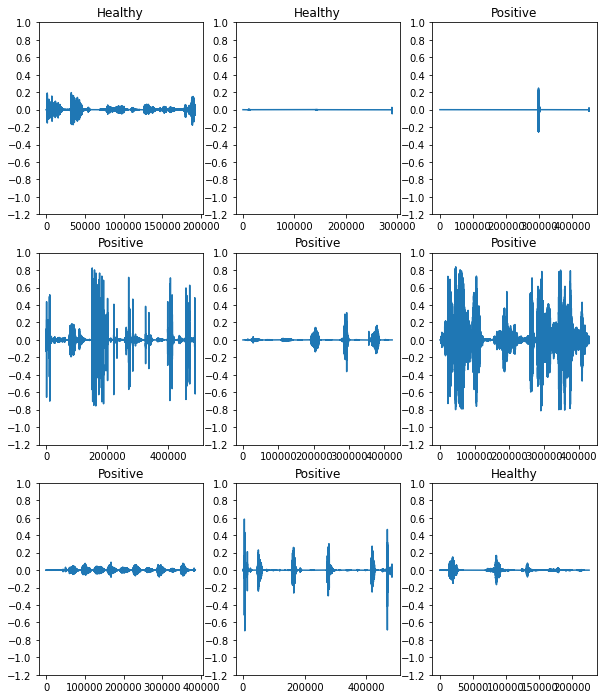

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [14]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [15]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

Label: Healthy
Waveform shape: (192512,)
Spectrogram shape: (124, 129)


In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

C:\Users\hafiz\AppData\Local\Temp/ipykernel_10248/3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


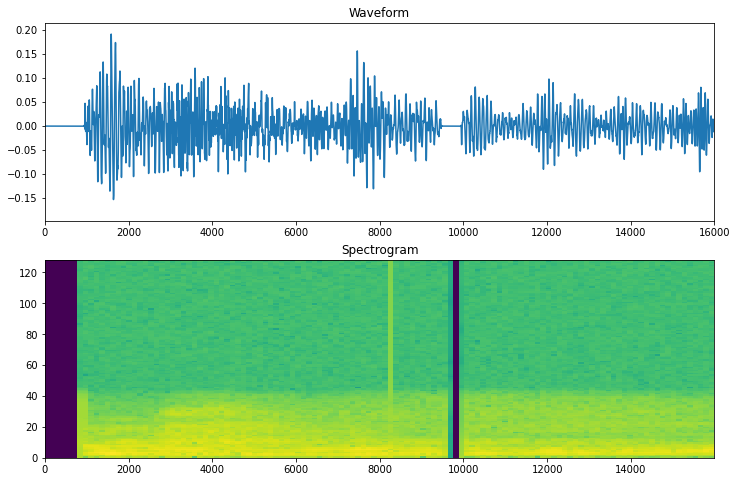

In [17]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [18]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [19]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

C:\Users\hafiz\AppData\Local\Temp/ipykernel_10248/3600643975.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


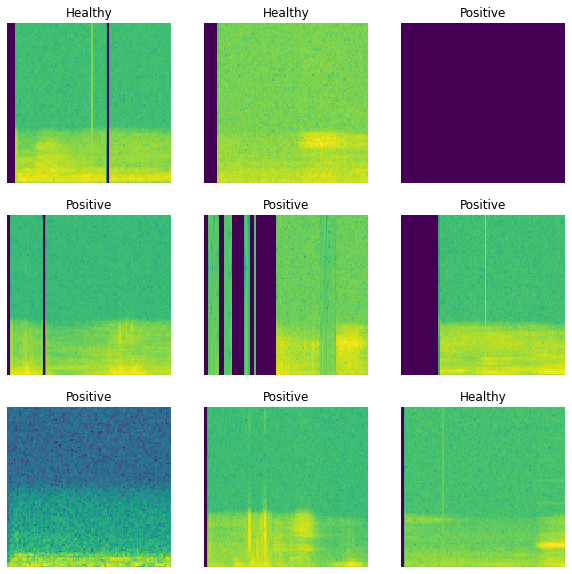

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [21]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [22]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [23]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [24]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [25]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

model = models.Sequential([
    layers.Input(shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

model.summary()

Input shape: (124, 129)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 124, 128)         99328     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 124, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [27]:
# Callbacks Function

class Callbacks(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(Callbacks, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

my_callback = Callbacks(threshold=0.91)

In [28]:
EPOCHS = 300
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[my_callback],
)

Epoch 1/300
5/5 [==============================] - 9s 472ms/step - loss: 0.6878 - accuracy: 0.5533 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 2/300
5/5 [==============================] - 0s 45ms/step - loss: 0.6711 - accuracy: 0.5773 - val_loss: 0.6890 - val_accuracy: 0.5278
Epoch 3/300
5/5 [==============================] - 0s 42ms/step - loss: 0.6596 - accuracy: 0.5911 - val_loss: 0.6883 - val_accuracy: 0.5278
Epoch 4/300
5/5 [==============================] - 0s 42ms/step - loss: 0.6445 - accuracy: 0.5945 - val_loss: 0.7045 - val_accuracy: 0.5278
Epoch 5/300
5/5 [==============================] - 0s 40ms/step - loss: 0.6267 - accuracy: 0.6564 - val_loss: 0.7128 - val_accuracy: 0.5278
Epoch 6/300
5/5 [==============================] - 0s 44ms/step - loss: 0.6028 - accuracy: 0.6667 - val_loss: 0.6851 - val_accuracy: 0.5833
Epoch 7/300
5/5 [==============================] - 0s 43ms/step - loss: 0.5748 - accuracy: 0.7079 - val_loss: 0.6677 - val_accuracy: 0.6111
Epoch 8/300
5/5 [==

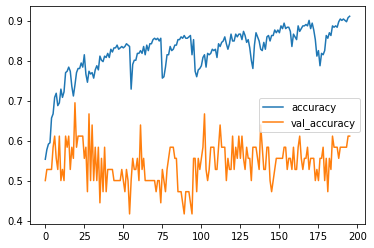

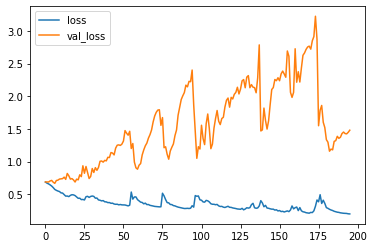

In [29]:
metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [30]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [31]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

2/2 [==============================] - 1s 16ms/step
Test set accuracy: 53%


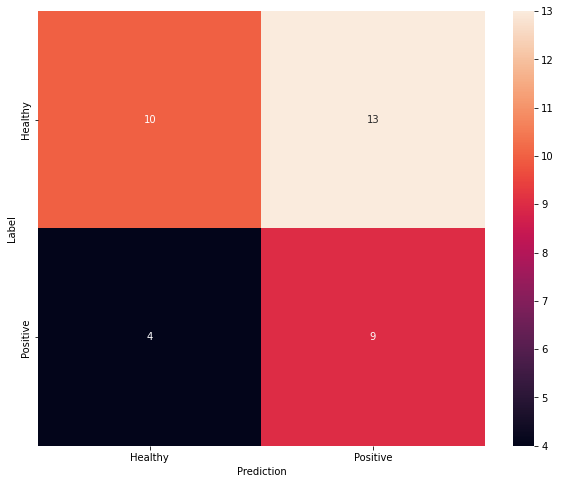

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

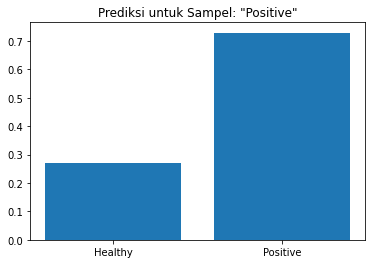

Hasil Prediksi:
27.11% Sehat
72.89% Positif


In [104]:
sample_file = data_dir/'Positive/breathing-shallow (100).wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  pred = tf.nn.softmax(prediction[0])
  plt.bar(commands, pred)
  plt.title(f'Prediksi untuk Sampel: "{commands[label[0]]}"')
  plt.show()

print("Hasil Prediksi:")
healthy_pred = tf.keras.backend.get_value(pred[0]) * 100
positive_pred = tf.keras.backend.get_value(pred[1]) * 100
print("%.2f%% Sehat" % (healthy_pred))
print("%.2f%% Positif" % (positive_pred))

In [52]:
# Save the model

# save_path = os.path.join(r"D:\Kuliah\.Misc\EUREKA ITB 2022\\", r"model/v1.3-91")
# tf.saved_model.save(model, save_path)

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.experimental_new_converter=True
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
# tf.lite.OpsSet.SELECT_TF_OPS]
# tflite_model = converter.convert()

# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

save_path = os.path.join(r"D:\Kuliah\.Misc\EUREKA ITB 2022\\", r"model/model.h5")
model.save(save_path, save_format="h5")